# **Open Circuit Potential (OCP) Balancing**

This notebook is created to provide an example of using PyBaMM-param package when balancing OCP curve with shifting and stretching the fitted curve to experimental data. This can also be found in `scripts/ocp_balance.py` as Python function.

In [1]:
%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import pbparam
import pandas as pd
import os
os.chdir(os.path.join(pbparam.__path__[0], "input", "data"))

We have 4 different files in this example. 2 for half-cell and 2 for three-electrode full cell. They are divided for their lithiation and delithiation stage.

In [2]:
#  .csv files are uploaded
anode_half_lit = pd.read_csv(os.path.join("anode_OCP_2_lit.csv"))
anode_half_delit = pd.read_csv(os.path.join("anode_OCP_2_delit.csv"))
anode_three_lit = pd.read_csv(os.path.join("anode_OCP_3_lit.csv"))
anode_three_delit = pd.read_csv(os.path.join("anode_OCP_3_delit.csv"))


Custom weights can be defined for cost function as single int or list of int with same length. This is optional and default is 1.

In [3]:
# the custom weights of the cost function. It can be int or 
# list of int that has same length as data. This is OPTIONAL.
weights = [2]

Then, optimisation problem should be passed to pbparam with the data to be used as below.

In [4]:
ocp_balance = pbparam.OCPBalance(
    [anode_three_lit, anode_three_delit],
    [anode_half_lit, anode_half_delit],
    weights=weights # the custom weights
)

Optimiser to minimise cost function should be selected in the nest step as below.

In [5]:
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

```optimiser.optimise(optimisation_problem)``` should be used to run minimasiation algorithm.

In [6]:
result = optimiser.optimise(ocp_balance)

c:\Users\Sogut2_M\Desktop\GitHub\pybamm-param\pbparam\optimisers\scipy_minimize.py:91: OptimizeWarning: Initial guess is not within the specified bounds
  raw_result = minimize(


shift and stretch values and final cost function value can be printed as below.

In [7]:
print(result)


             Optimal values: [6.27049251e-09 2.07540677e-01]
        Cost function value: 0.49596955186463054
                 Solve time: 38.436 ms
                    Message: Optimization terminated successfully.
        


PyBaMM-param has built in plot function to represent results.

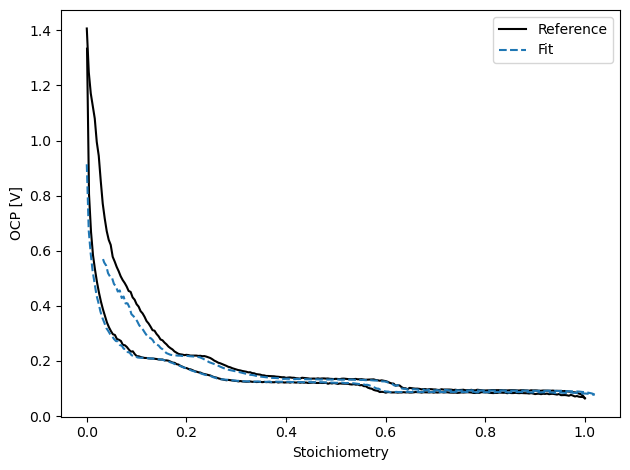

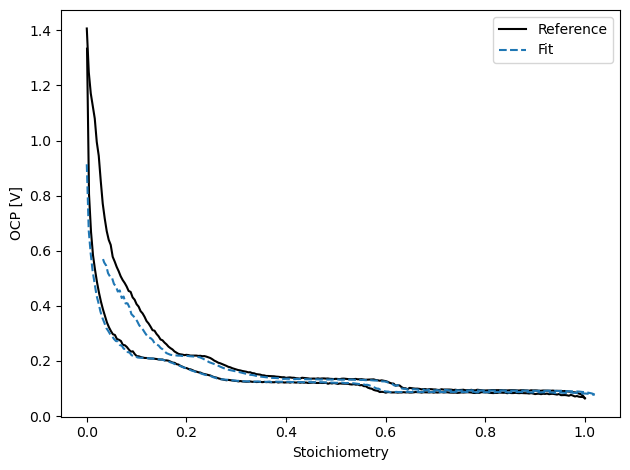

In [8]:
result.plot()